In [1]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - 0.29) / 0.35 for o in b['image']]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([0, 5, 1, 3, 3, 5, 1, 8, 7, 3]))

In [2]:
xb.mean(), xb.std()

(tensor(-0.0049), tensor(1.0048))

In [3]:
from torch import nn

import torch
import numpy as np

class GeneralRelu(nn.Module):
    def __init__(self, leak=0.1, sub=0.4, maxv=2):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, GeneralRelu())
    return res

def get_model():
    layers = [conv(1,8),            #14x14
    conv(8,16),            #7x7
    conv(16,32),           #4x4
    conv(32,64),           #2x2
    conv(64,10, act=False), #1x1
    nn.Flatten()]
    model = nn.Sequential(*layers)
    return model

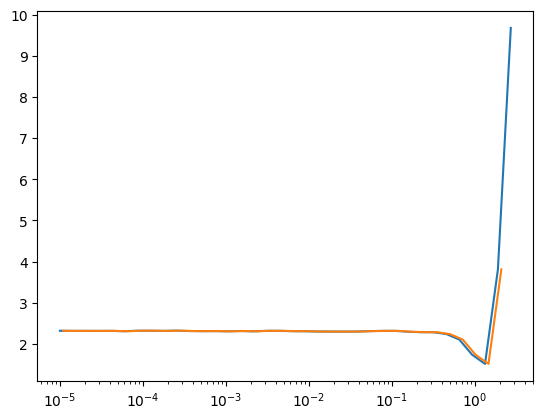

In [4]:
import miniai
from miniai.learner import MomentumLearner as Learner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LRFinderCB(gamma=1.1), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.lr_find()

accuracy,loss,epoch,train
0.592,1.111,0,train
0.798,0.543,0,eval


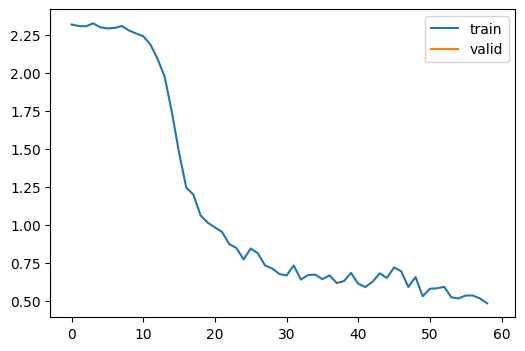

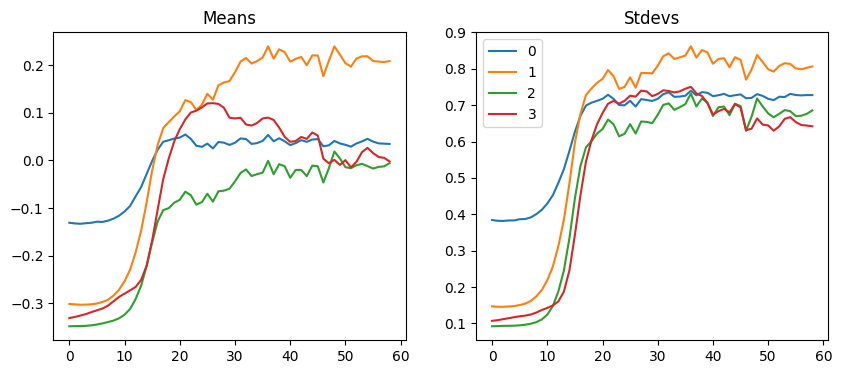

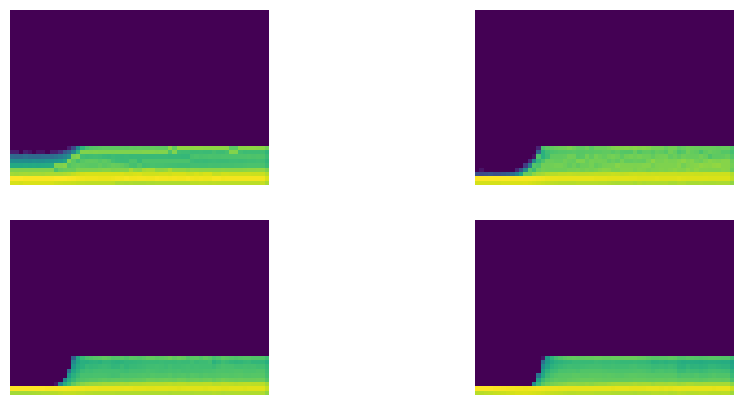

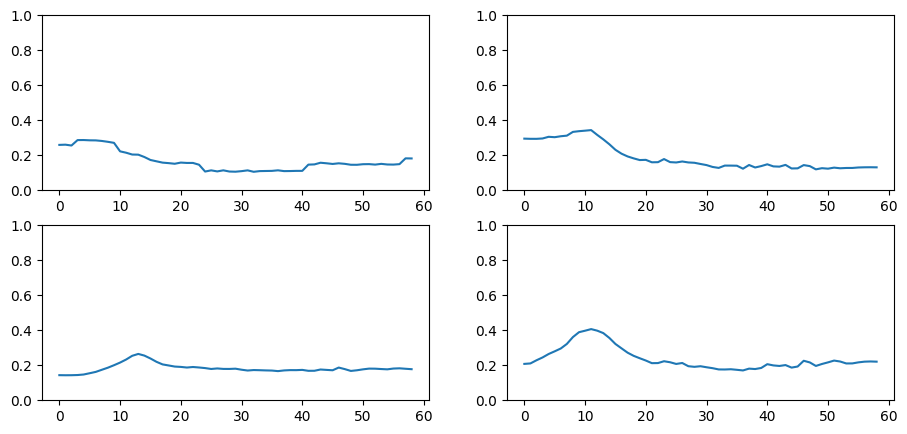

In [6]:
from miniai.activations import ActivationStats
import fastcore.all as fc

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2,cbs=cbs)
learn.fit(1)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [33]:
from miniai.activations import Hook, Hooks

from functools import partial

def hook_function(self, module, input, output):
    print(output.mean(), output.std())
    module[0].weight.data = module[0].weight.data / output.std()
    module[0].bias.data = module[0].bias.data - output.mean()

def norm_output(module):
    hook = Hook(module, hook_function)
    for i in range(10):
        model(xb)
    print('----')
    hook.remove()
    
model = get_model()

In [34]:
for layer in model[0:4]:
    print(layer)
    norm_output(layer)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): GeneralRelu()
)
tensor(-0.2572, grad_fn=<MeanBackward0>) tensor(0.2821, grad_fn=<StdBackward0>)
tensor(0.2921, grad_fn=<MeanBackward0>) tensor(0.9765, grad_fn=<StdBackward0>)
tensor(0.1741, grad_fn=<MeanBackward0>) tensor(0.9401, grad_fn=<StdBackward0>)
tensor(0.1255, grad_fn=<MeanBackward0>) tensor(0.9427, grad_fn=<StdBackward0>)
tensor(0.0988, grad_fn=<MeanBackward0>) tensor(0.9534, grad_fn=<StdBackward0>)
tensor(0.0799, grad_fn=<MeanBackward0>) tensor(0.9637, grad_fn=<StdBackward0>)
tensor(0.0649, grad_fn=<MeanBackward0>) tensor(0.9721, grad_fn=<StdBackward0>)
tensor(0.0528, grad_fn=<MeanBackward0>) tensor(0.9784, grad_fn=<StdBackward0>)
tensor(0.0429, grad_fn=<MeanBackward0>) tensor(0.9831, grad_fn=<StdBackward0>)
tensor(0.0348, grad_fn=<MeanBackward0>) tensor(0.9868, grad_fn=<StdBackward0>)
----
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): General

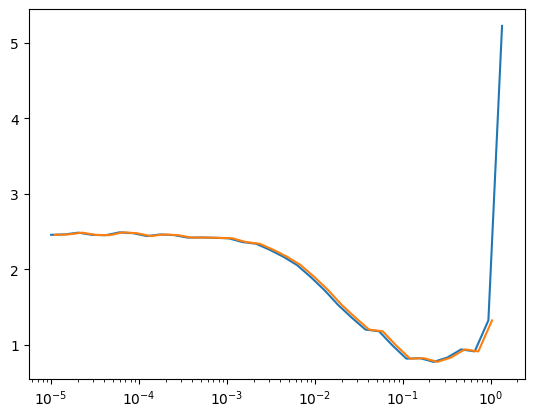

In [35]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LRFinderCB(gamma=1.1), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.lr_find()

accuracy,loss,epoch,train
0.738,1.231,0,train
0.786,0.628,0,eval


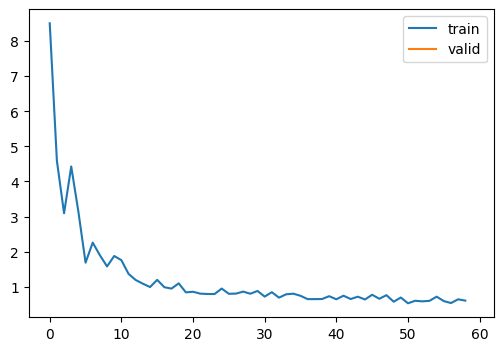

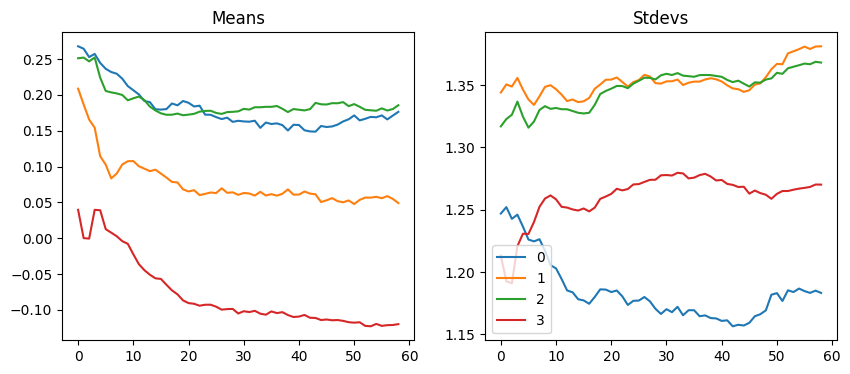

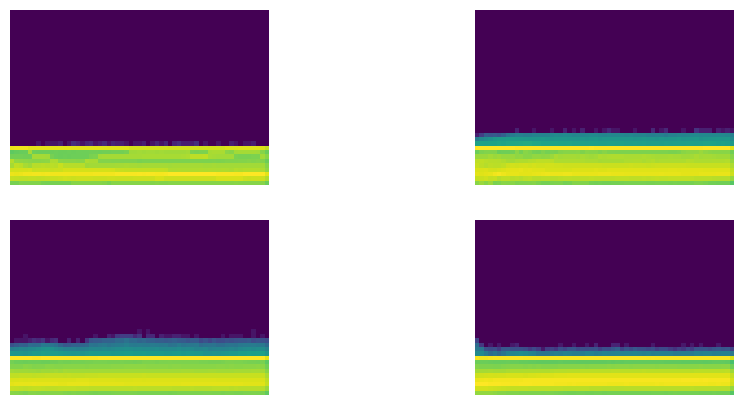

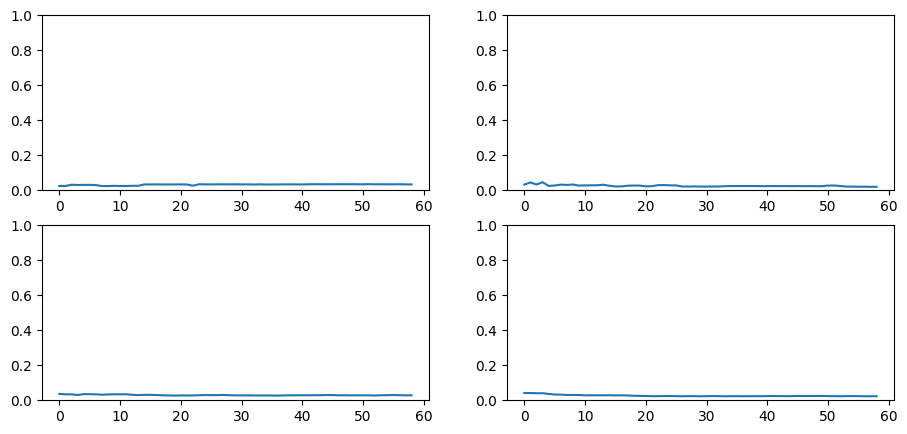

In [36]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(model, dls, F.cross_entropy, lr=0.1,cbs=cbs)
learn.fit(1)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

accuracy,loss,epoch,train
0.828,0.508,0,train
0.818,0.518,0,eval
0.842,0.447,1,train
0.825,0.499,1,eval
0.849,0.416,2,train
0.833,0.489,2,eval


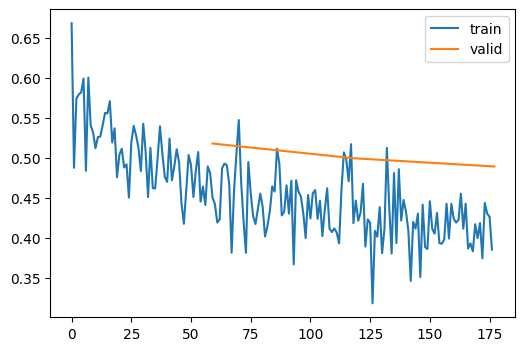

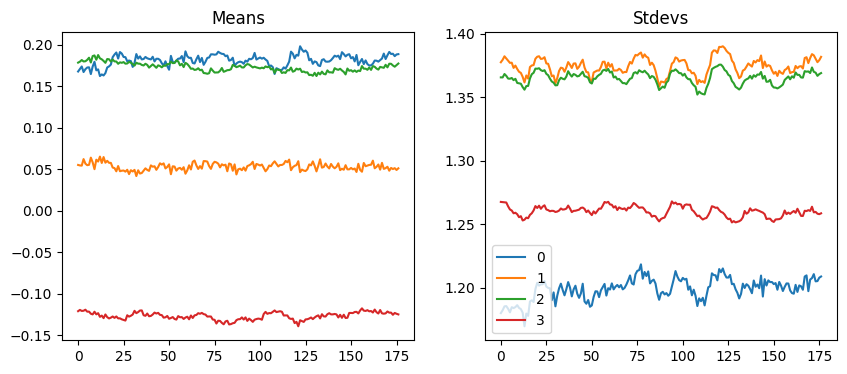

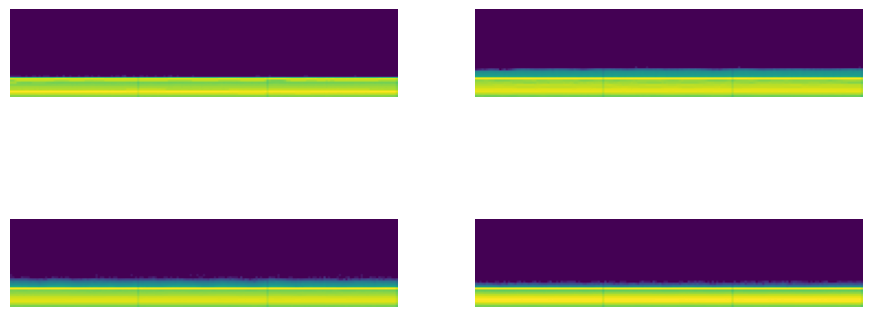

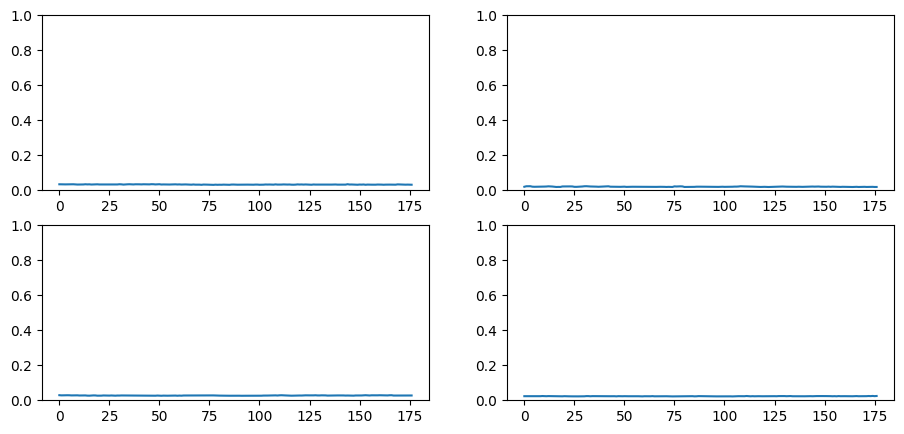

In [37]:
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()